In [ ]:
## 0. Load Data

In [1]:
from __future__ import print_function
import sys, os
import tempfile, urllib, zipfile

# Set up some globals for our file paths
BASE_DIR = tempfile.mkdtemp()
DATA_DIR = os.path.join(BASE_DIR, 'data/taxi/')
OUTPUT_DIR = os.path.join(BASE_DIR, 'chicago_taxi_output')
TRAIN_DATA = os.path.join(DATA_DIR, 'train', 'data.csv')
EVAL_DATA = os.path.join(DATA_DIR, 'eval', 'data.csv')
SERVING_DATA = os.path.join(DATA_DIR, 'serving', 'data.csv')

# Download the zip file from GCP and unzip it
zip, headers = urllib.request.urlretrieve('https://storage.googleapis.com/tfx-colab-datasets/chicago_data.zip')
zipfile.ZipFile(zip).extractall(BASE_DIR)
zipfile.ZipFile(zip).close()

print("Here's what we downloaded:")
!ls -R {os.path.join(BASE_DIR, 'data')}

Here's what we downloaded:
eval    serving train

/var/folders/gm/yftb1thj7rl4hwccxwffhpmc0000gn/T/tmpql7omx4z/data/eval:
data.csv

/var/folders/gm/yftb1thj7rl4hwccxwffhpmc0000gn/T/tmpql7omx4z/data/serving:
data.csv

/var/folders/gm/yftb1thj7rl4hwccxwffhpmc0000gn/T/tmpql7omx4z/data/train:
data.csv


In [2]:
from profiler.core import *

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [3]:
pf = Profiler(workers=2, tol=0, eps=0.05, embedtxt=False)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [4]:
pf.session.load_data(name='hospital', src=FILE, fpath='/var/folders/gm/yftb1thj7rl4hwccxwffhpmc0000gn/T/tmpql7omx4z/data/eval/data.csv', check_param=True)

INFO:profiler.utility:[20.23355007171631] Load Data start

INFO:profiler.dataset:parameters used for data loading:
 {'na_values': {'', 'unknown', 'none', '?', 'nan', 'NaN', 'None'}, 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.dataset:inferred types of attributes: {
    "pickup_community_area": "numeric",
    "fare": "numeric",
    "trip_start_month": "numeric",
    "trip_start_hour": "numeric",
    "trip_start_day": "numeric",
    "trip_start_timestamp": "numeric",
    "pickup_latitude": "numeric",
    "pickup_longitude": "numeric",
    "dropoff_latitude": "numeric",
    "dropoff_longitude": "numeric",
    "trip_miles": "numeric",
    "dropoff_census_tract": "numeric",
    "payment_type": "categorical",
    "company": "text",
    "trip_seconds": "numeric",
    "dropoff_community_area": "numeric",
    "tips": "numeric"
}
INFO:profiler.dataset:(possible types: numeric, categoric

In [5]:
pf.session.ds.df.head()

,pickup_community_area,fare,trip_start_month,trip_start_hour,trip_start_day,trip_start_timestamp,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_miles,dropoff_census_tract,payment_type,company,trip_seconds,dropoff_community_area,tips
0,60,27.05,10,2,3,1380593700,41.836150,-87.648788,NaN,NaN,12.6,NaN,cash,taxi affiliation services,1380.0,NaN,0.0
1,10,5.85,10,1,2,1382319000,41.985015,-87.804532,NaN,NaN,0.0,NaN,cash,taxi affiliation services,180.0,NaN,0.0
2,14,16.65,5,7,5,1369897200,41.968069,-87.721559,NaN,NaN,0.0,NaN,cash,dispatch taxi affiliation,1080.0,NaN,0.0
3,13,16.45,11,12,3,1446554700,41.983636,-87.723583,NaN,NaN,6.9,NaN,cash,nan,780.0,NaN,0.0
4,16,32.05,12,1,1,1417916700,41.953582,-87.723452,NaN,NaN,15.4,NaN,cash,nan,1200.0,NaN,0.0


### 2.1 Change Data Types of Attributes
* required input:
    * a list of attributes
    * a list of data types (must match the order of the attributes; can be CATEGORICAL, NUMERIC, TEXT, DATE)
* optional input:
    * a list of regular expression extractor

In [6]:
# pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample'], 
#                             [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC],
#                             [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients'])

### 2.2. Load/Train Embeddings for TEXT
* path: path to saved/to-save embedding folder
* load: set to true -- load saved vec from 'path'; set to false -- train locally
* save: (only for load = False) save trained vectors to 'path'

In [7]:
#pf.session.load_embedding(save=True, path='data/hospital/', load=True)

## 3. Load Training Data
* multiplier: if set to None, will infer the minimal sample size; otherwise, it will create (# samples) * (# attributes) * (multiplier) training samples

In [8]:
pf.session.load_training_data(multiplier = None)

INFO:profiler.utility:[23.69245409965515] Create Training Data start

INFO:profiler.transformer:needs multiplier = 33 to bound the error in inv cov estimation <= 0.05000000
INFO:profiler.transformer:use multiplier = 33, and the bound is 0.00007298
INFO:profiler.transformer:Draw Pairs
100%|██████████| 17/17 [00:00<00:00, 72.61it/s]
INFO:profiler.transformer:Number of training samples: 170000
INFO:profiler.transformer:Computing Differences
INFO:profiler.transformer:estimated missing data probability in training data is 0.0319
INFO:profiler.utility:[24.87323307991028] Create Training Data execution time: 1.180778980255127



## 4. Learn Structure
* sparsity: intensity of L1-regularizer in inverse covariance estimation (glasso)
* take_neg: if set to true, consider equal -> equal only

In [9]:
autoregress_matrix = pf.session.learn_structure(sparsity=0.05, infer_order=True)

INFO:profiler.utility:[24.887467861175537] Learn Structure start

INFO:profiler.learner:use threshold 0.0278
INFO:profiler.utility:[25.340178966522217] Learn Structure execution time: 0.4527111053466797



* score: 
    * "fit_error": mse for fitting y = B'X + c for each atttribute y 
    * "training_data_fd_vio_ratio": the higher the score, the more violations of FDs in the training data. (bounded: \[0,1\])

In [10]:
parent_sets = pf.session.get_dependencies(score="fit_error")

INFO:profiler.utility:[25.35340690612793] Get Dependencies start

INFO:profiler.utility:[25.487332105636597] Get Dependencies execution time: 0.133925199508667



payment_type -> tips (0.12209676262238485)
dropoff_longitude -> dropoff_latitude (0.007598284957754267)
dropoff_longitude,dropoff_latitude -> dropoff_census_tract (0.0658857863213891)
dropoff_longitude,dropoff_latitude,dropoff_census_tract -> dropoff_community_area (0.09705145473340954)
dropoff_longitude,dropoff_latitude -> pickup_latitude (0.22100916452590377)
dropoff_longitude,dropoff_latitude,pickup_latitude -> pickup_longitude (0.006678054310430508)
pickup_latitude,pickup_longitude -> pickup_community_area (0.09368504808603167)


## 5. Visualization

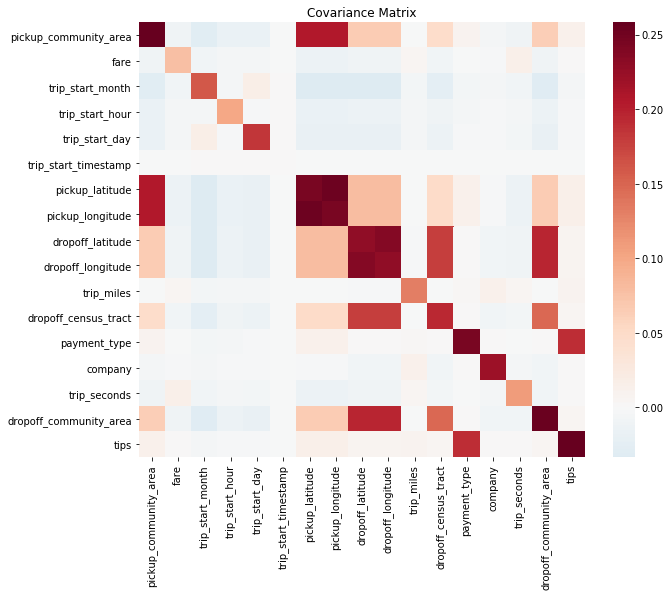

In [15]:
pf.session.visualize_covariance()

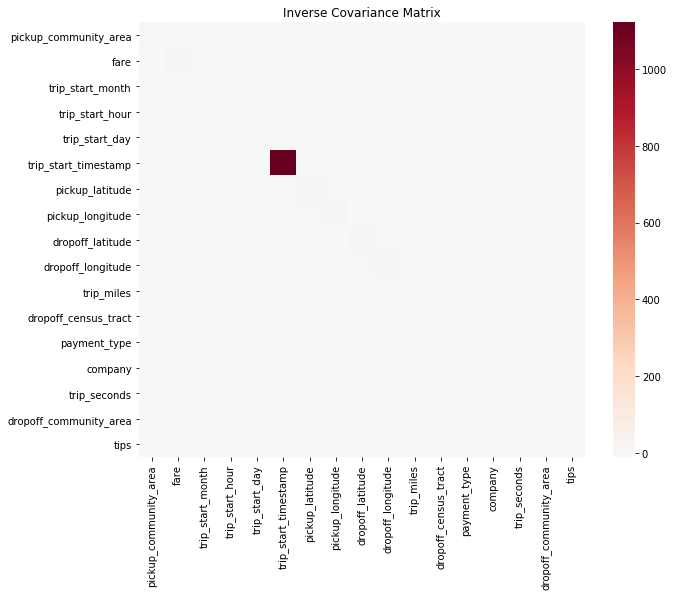

In [12]:
pf.session.visualize_inverse_covariance()

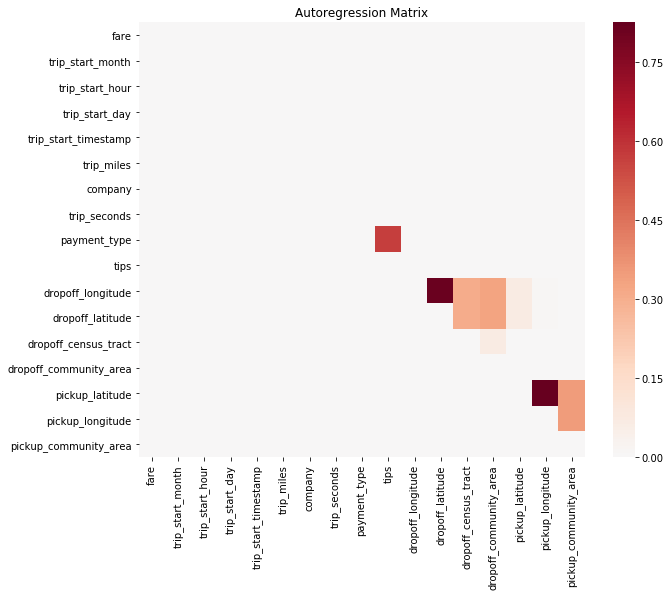

In [13]:
pf.session.visualize_autoregression()

In [14]:
pf.session.timer.get_stat()

,time_point,msg,execution_time
0,20.233550,start: Load Data,0.000000
1,20.382189,end: Load Data,0.148639
2,23.692454,start: Create Training Data,0.000000
3,24.873233,end: Create Training Data,1.180779
4,24.887468,start: Learn Structure,0.000000
5,25.340179,end: Learn Structure,0.452711
6,25.353407,start: Get Dependencies,0.000000
7,25.487332,end: Get Dependencies,0.133925
8,25.487332,total_execution_time,1.916054


In [16]:
import matplotlib.pyplot as plt

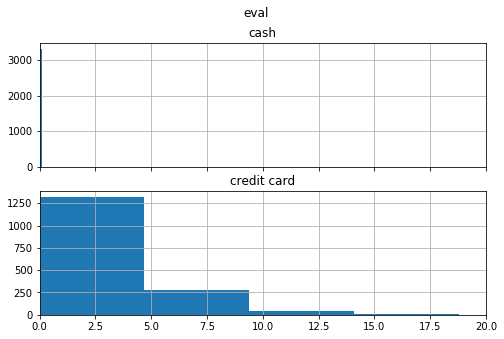

In [31]:
fig, axs = plt.subplots(2, figsize=(8,5), sharex=True)
i = 0
fig.suptitle('eval')
for cls, group in pf.session.ds.df.groupby(['payment_type']):
    if cls == "prcard":
        continue
    if cls == "dispute":
        break
    group['tips'].hist(bins=10, ax=axs[i])
    axs[i].set_title(cls)
    axs[i].set_xlim(left=0,right=20)
    i += 1

In [38]:
for cls, group in pf.session.ds.df.groupby(['payment_type']):
#     if cls == "cash":
#         break
    if cls == "credit card":
        break

In [41]:
count, bins = np.histogram(group.tips, bins=[ 0.   ,  2.655,  5.31 ,  7.965, 10.62 , 13.275, 15.93 , 18.585,
       21.24 , 23.895, 26.55 ])

In [42]:
bins

array([ 0.   ,  2.655,  5.31 ,  7.965, 10.62 , 13.275, 15.93 , 18.585,
       21.24 , 23.895, 26.55 ])

In [44]:
count

array([924, 456, 162,  85,  12,   6,   2,   1,   0,   0])